In [1]:
# Import dependencies
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model, model_from_json
from keras.optimizers import RMSprop
from keras.layers import Dropout, Flatten, Dense, Conv2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.applications.vgg16 import preprocess_input, VGG16
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import pickle
import cv2
import os
from shutil import copy

Using TensorFlow backend.


In [2]:
classifer = 'gender'

In [3]:
train_dir = './data/trainset/' + classifer + '/train'
test_dir = './data/trainset/' + classifer + '/test'

In [4]:
batch_size = 20

In [5]:
def generator(directory, shuffle=False):
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen.flow_from_directory(
        directory, 
        target_size=(224, 224), 
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=shuffle)

In [6]:
def features(directory, generator, model):
    
    n = len(sorted(list(paths.list_images(directory))))
    features = np.zeros(shape=(n, 7, 7, 512))
    labels = np.zeros(shape=(n, 2))
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i * batch_size >= n:
            break
    
    return np.reshape(features, (n, 7 * 7 * 512)), labels

In [7]:
def VGG_model():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Conv2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    model.load_weights('vgg_face_weights.h5')
    return Model(inputs=model.layers[0].input,
                 outputs=model.layers[-2].output)

In [8]:
vgg_conv = VGG16(weights="imagenet", 
                 include_top=False, 
                 input_shape=(224, 224, 3))

### Train Model Set

In [9]:
train_gen = generator(train_dir, shuffle=True)

Found 966 images belonging to 2 classes.


In [10]:
train_features, train_label = features(train_dir, train_gen, vgg_conv)

### Test Model Set

In [13]:
vaidation_gen = generator(test_dir)

Found 241 images belonging to 2 classes.


In [14]:
validation_features, validation_labels = features(test_dir, vaidation_gen, vgg_conv)

### Expand The Model

In [18]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_label,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 966 samples, validate on 241 samples
Epoch 1/20
966/966 [==============================] - 5s 5ms/step - loss: 1.2757 - acc: 0.6718 - val_loss: 0.3508 - val_acc: 0.8216
Epoch 2/20
966/966 [==============================] - 4s 5ms/step - loss: 0.4807 - acc: 0.8033 - val_loss: 0.2685 - val_acc: 0.9087
Epoch 3/20
966/966 [==============================] - 4s 5ms/step - loss: 0.2943 - acc: 0.8799 - val_loss: 0.1505 - val_acc: 0.9419
Epoch 4/20
966/966 [==============================] - 4s 5ms/step - loss: 0.2535 - acc: 0.8965 - val_loss: 0.1585 - val_acc: 0.9253
Epoch 5/20
966/966 [==============================] - 4s 5ms/step - loss: 0.2130 - acc: 0.9275 - val_loss: 0.0941 - val_acc: 0.9710
Epoch 6/20
966/966 [==============================] - 5s 5ms/step - loss: 0.1930 - acc: 0.9151 - val_loss: 0.0959 - val_acc: 0.9585
Epoch 7/20
966/966 [==============================] - 5s 5ms/step - loss: 0.1584 - acc: 0.9493 - val_loss: 0.0984 - val_acc: 0.9544
Epoch 8/20
966/966 [==========

In [25]:
fnames = vaidation_gen.filenames

ground_truth = vaidation_gen.classes

label2index = vaidation_gen.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [26]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

In [28]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),len(sorted(list(paths.list_images(test_dir))))))

No of errors = 4/241


Original label:female, Prediction :male, confidence : 0.527


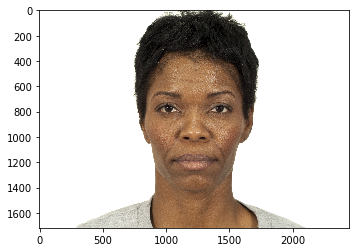

Original label:male, Prediction :female, confidence : 0.998


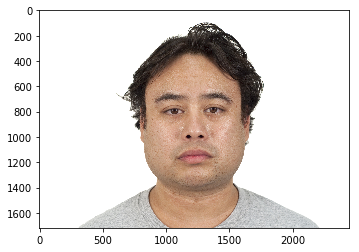

Original label:male, Prediction :female, confidence : 0.819


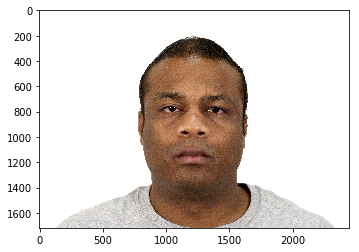

Original label:male, Prediction :female, confidence : 0.986


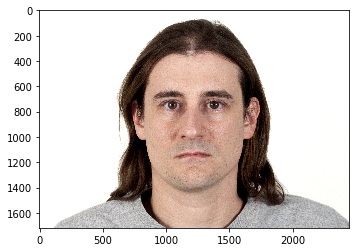

In [30]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()

In [35]:
sorted(list(paths.list_images(test_dir)))[0]

'./data/trainset/gender/test/female/CFD-AF-201-060-N.jpg'

### Save Model

In [36]:
model.save('gender_classifier.h5')

### TEST

In [ ]:
test_prob = model.predict()